# 线性回归的从零开始实现
从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## 3.2.1. 生成数据集
生成带有噪声的数据集

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))   # 将X和y变为列向量返回

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.3551,  0.2871]) 
label: tensor([2.5056])


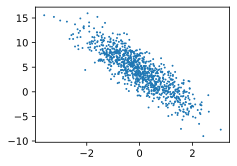

In [4]:
d2l.set_figsize()
# detach阻断反向传播，返回值仍为tensor
# numpy()将tensor转换为numpy
# 1为点大小
d2l.plt.scatter(features[:, 1].detach().numpy(), 
                labels.detach().numpy(), 
                1)   

## 3.2.2. 读取数据集
定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)   # 获得样本个数
    indices = list(range(num_examples))   # 样本索引
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)   # 将索引打乱，使用随机的顺序访问样本
    for i in range(0, num_examples, batch_size):
        # 获得每个batch_size的数据，但是最后一批数据可能不足一个batch_size
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6884,  0.0360],
        [ 0.0064,  1.3322],
        [ 0.5941,  1.8335],
        [ 1.4785,  0.1336],
        [-0.5797,  1.1766],
        [ 0.6335,  0.6685],
        [ 0.7190,  1.4561],
        [-0.7094, -1.1297],
        [ 2.1083, -1.0152],
        [ 0.7173,  1.1890]]) 
 tensor([[ 2.7079],
        [-0.3374],
        [-0.8521],
        [ 6.6975],
        [-0.9606],
        [ 3.1939],
        [ 0.6957],
        [ 6.6157],
        [11.8818],
        [ 1.6022]])


## 3.2.3. 初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 3.2.4. 定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 3.2.5. 定义损失函数

In [9]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2   # 为防止数据维度形状不同一，转换为同样的形状

## 3.2.6. 定义优化算法

In [10]:
# 从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    
    # 更新的时候不需要梯度计算
    with torch.no_grad():
        for param in params:
            
            # 损失函数中的均方误差没有除以均值，在更新参数时处理一样
            param -= lr * param.grad / batch_size
            
            # 将参数归零为下一次计算做准备，若未归零下次计算会与本次相关
            param.grad.zero_()

## 3.2.7. 训练

In [11]:
lr = 0.03
num_epochs = 3
net = linreg   # 代码模块化思想，将方法赋给net，当需要改变方法时此处仅需要更改方法即可
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):   # 使用data_iter函数遍历整个数据集
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数（此处batch_size的最后一个可能不满足数量，具体问题还需具体对待）
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033670
epoch 2, loss 0.000118
epoch 3, loss 0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0008, -0.0011], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


In [14]:
help(d2l.synthetic_data)

Help on function synthetic_data in module d2l.torch:

synthetic_data(w, b, num_examples)
    Generate y = Xw + b + noise.



## 3.3.2. 读取数据集

In [15]:
# 将features和labels作为API的参数传递，并在实例化数据迭代器对象时指定batch_size
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    # TensorDataset对给定的tensor数据(样本和标签)，将它们包装成dataset
    dataset = data.TensorDataset(*data_arrays)  
    # DataLoader数据加载器，组合数据集和采样器，并在数据集上提供单进程或多进程迭代器。它可以对我们上面所说的数据集Dataset作进一步的设置
    return data.DataLoader(dataset, batch_size, shuffle=is_train)   

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [16]:
next(iter(data_iter))

[tensor([[ 9.5080e-01, -2.0373e+00],
         [-1.0640e+00, -2.1435e-01],
         [-4.3000e-01,  9.4376e-01],
         [ 9.8614e-01,  1.0644e+00],
         [-8.4261e-01, -1.8559e-03],
         [ 8.4833e-01, -6.9257e-01],
         [-6.2921e-01,  8.4508e-01],
         [-1.8457e-01,  4.0644e-01],
         [ 1.0014e+00,  1.2696e-01],
         [-2.0928e+00,  3.0131e-01]]),
 tensor([[13.0223],
         [ 2.7822],
         [ 0.1302],
         [ 2.5614],
         [ 2.5138],
         [ 8.2389],
         [ 0.0727],
         [ 2.4542],
         [ 5.7773],
         [-1.0059]])]

## 3.3.3. 定义模型

In [17]:
# `nn` 是神经网络的缩写
from torch import nn

# 首先定义一个模型变量net，它是一个Sequential类的实例
# Sequential类为串联在一起的多个层定义了一个容器
# nn.Sequential是一个容器，模块将按照它们在构造函数中传递的顺序添加到它
# 将两个参数传递到nn.Linear中。第一个指定输入特征形状，第二个指定输出特征形状
net = nn.Sequential(nn.Linear(2, 1))

## 3.3.4. 初始化模型参数

In [18]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 3.3.5. 定义损失函数

In [19]:
# MSELoss类，也称为平方L2范数。默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

## 3.3.6. 定义优化算法

In [20]:
# 实例化SGD实例时要指定优化的参数（可通过net.parameters()从模型中获得）以及优化算法所需的超参数字典。
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 3.3.7. 训练

In [21]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()   # 这里pytorch已经做了sum
        trainer.step()   # 进行一次模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000251
epoch 2, loss 0.000104
epoch 3, loss 0.000104
